In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#First model--simple implementaiton of JMS's model

from src.jms_model.py import HandicapModel

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(generations), p_B_values, label='male handicap allele')
plt.plot(range(generations), p_C_values, label='female preference allele', linestyle='dashed')
plt.xlabel("Generations")

# Maynard Smith's original model was investigated after just 5 generations.
plt.xlim(0,5)

plt.ylabel("Allele Frequency")
plt.title("Evolution of Allele Frequencies Over Time")
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'src'

In [1]:
#Next Model--let's extend it to incorporate additional realism, involving developmental constraints and quantitative sex-linked traits.
import numpy as np

class BaseHandicapModel:
    def __init__(self, pop_size=1000, k=1.5, preference_strength=3.0, mutation_std=0.05, max_handicap=3.0):
        self.pop_size = pop_size
        self.k = k
        self.preference_strength = preference_strength
        self.mutation_std = mutation_std
        self.max_handicap = max_handicap
        self.history = []

    def survival_prob(self, h):
        return np.exp(-self.k * h)

    def mating_probabilities(self, handicaps):
        scaled = self.preference_strength * handicaps
        exp_vals = np.exp(scaled - np.max(scaled))
        return exp_vals / np.sum(exp_vals)
        

class SexLinkedHandicapModel(BaseHandicapModel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.male_handicaps = np.full(self.pop_size, 0.1)  # Low initial value
        self.extinct = False  # Flag to track if the population has gone extinct

    def update_generation(self):
        # Calculate survival probabilities and apply them
        survival_probs = self.survival_prob(self.male_handicaps)
        survived = np.random.rand(self.pop_size) < survival_probs
        survivors = self.male_handicaps[survived]

        # If no survivors, set all handicaps to zero but continue the simulation
        if len(survivors) == 0:
            self.male_handicaps = np.zeros(self.pop_size)
            self.extinct = True  # Mark the population as extinct, but continue the simulation
            return  # No further calculations are needed for this generation
        
        # Calculate mating probabilities and select fathers
        mating_probs = self.mating_probabilities(survivors)
        fathers = np.random.choice(survivors, size=self.pop_size, p=mating_probs)

        # Generate offspring with mutations and clipping to max_handicap
        offspring = fathers + np.random.normal(0, self.mutation_std, size=self.pop_size)
        offspring = np.clip(offspring, 0, self.max_handicap)

        # Update male handicaps with the new offspring
        self.male_handicaps = offspring
        self.history.append(np.mean(self.male_handicaps))
        
class NonSexLinkedHandicapModel(BaseHandicapModel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.handicaps = np.full(self.pop_size, 0.1)
        self.sex = np.random.choice(['M', 'F'], size=self.pop_size)

    def update_generation(self):
        survival_probs = self.survival_prob(self.handicaps)
        survived_mask = np.random.rand(self.pop_size) < survival_probs
        self.handicaps = self.handicaps[survived_mask]
        self.sex = self.sex[survived_mask]

        males = self.handicaps[self.sex == 'M']
        females = self.handicaps[self.sex == 'F']

        if len(males) == 0 or len(females) == 0:
            self.handicaps = np.zeros(self.pop_size)
            return

        mating_probs = self.mating_probabilities(males)
        fathers = np.random.choice(males, size=self.pop_size, p=mating_probs)
        mothers = np.random.choice(females, size=self.pop_size)

        offspring_handicaps = (fathers + mothers) / 2 + np.random.normal(0, self.mutation_std, size=self.pop_size)
        offspring_handicaps = np.clip(offspring_handicaps, 0, self.max_handicap)
        offspring_sex = np.random.choice(['M', 'F'], size=self.pop_size)

        self.handicaps = offspring_handicaps
        self.sex = offspring_sex
        self.history.append(np.mean(self.handicaps))

# --- Run extended simulation ---
sex_linked = SexLinkedHandicapModel()
non_sex_linked = NonSexLinkedHandicapModel()

generations = 1000
for _ in range(generations):
    sex_linked.update_generation()
    non_sex_linked.update_generation()


if __name__ == "__main__":
    sex_linked = SexLinkedHandicapModel()
    non_sex_linked = NonSexLinkedHandicapModel()

    generations = 1000
    for _ in range(generations):
        sex_linked.update_generation()
        non_sex_linked.update_generation()

    print("Simulation complete!")
    print("Final average handicap (sex-linked):", sex_linked.history[-1])
    print("Final average handicap (non-sex-linked):", non_sex_linked.history[-1])

Simulation complete!
Final average handicap (sex-linked): 2.9349824950386045
Final average handicap (non-sex-linked): 0.17343426379713614


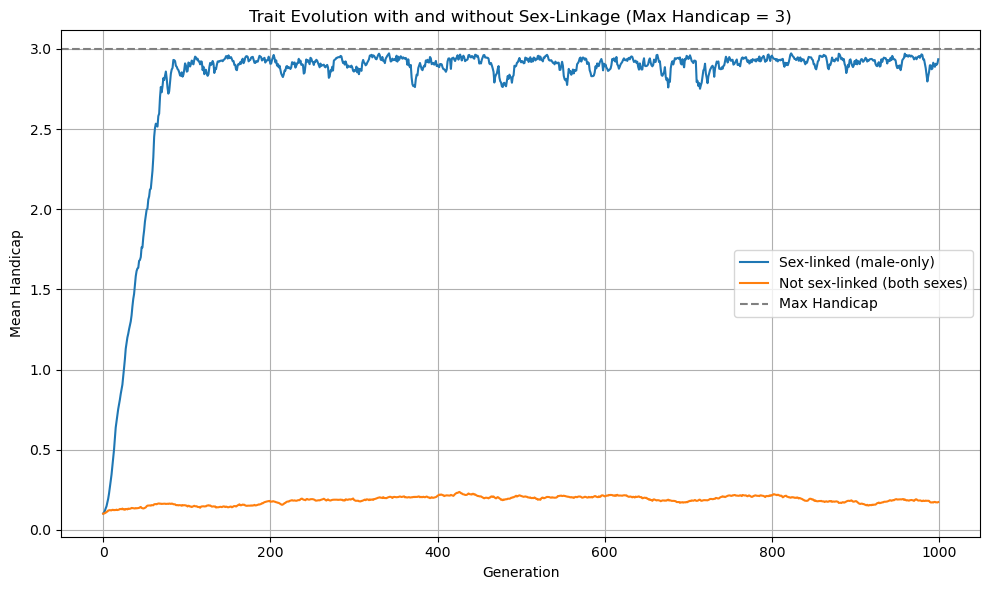

In [4]:
# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(sex_linked.history, label="Sex-linked (male-only)")
plt.plot(non_sex_linked.history, label="Not sex-linked (both sexes)")
plt.axhline(y=3.0, linestyle='--', color='gray', label="Max Handicap")
plt.xlabel("Generation")
plt.ylabel("Mean Handicap")
plt.title("Trait Evolution with and without Sex-Linkage (Max Handicap = 3)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
